In [14]:
import numpy as np
import matplotlib.pyplot as plt
import functools
import torch
from densities import uniform_rect_regions as pdf

In [15]:
densties = ['custom']
regions = [
        torch.tensor([[.0, .3]]),
        torch.tensor([[.6, .9]])
        ]
weights = [.5, .5]

In [16]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    return np.where(((x > 0) & (x < 1)), 1, 0)
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)

In [ ]:
def differentiable_sampling(pdf, n_samples, x_range = (1e-2,1 - 1e-2), max_pdf = 11):
    # Assuming the pdf is normalized so that it integrates to 1 over the range
    samples = []
    gen_samples = 0
    while gen_samples < n_samples:
        # Sample x_candidate from the range
        x_candidate = torch.rand(1) * (x_range[1] - x_range[0]) + x_range[0]
        
        # Sample y_candidate from a uniform distribution between 0 and 1
        y_candidate = torch.rand(1) * max_pdf
        
        # Compute the probability of acceptance as a soft threshold
        acceptance_probability = torch.sigmoid(pdf(x_candidate) - y_candidate)  # smooth function to decide acceptance
        try:
            accept = torch.bernoulli(acceptance_probability)
        except:
            #print(x_candidate)
            ## sometimes pdf generates division by 0 error --> nan
            continue
        
        # Only append x_candidate if accepted, but using a differentiable approximation
        if accept.item(): 
            sample = x_candidate * accept
            #print(accept, x_candidate)
            samples.append(sample)
            gen_samples += 1
    
    return torch.cat(samples)

0.15000000000000002 amp
0.75 vert
0.15 amp
0.15 vert
Generated Tensor:
torch.Size([2000, 1, 1, 1])


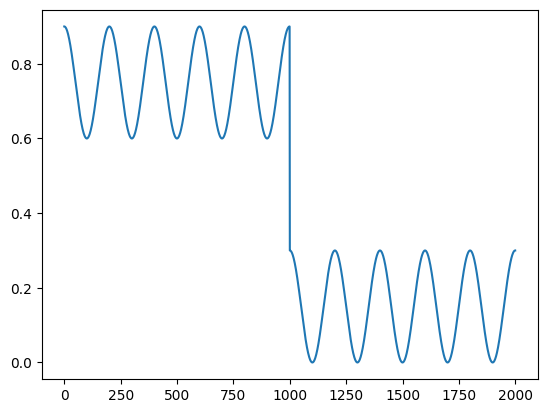

In [17]:
# Function to generate the desired cosine wave for a given range and frequency
def generate_cosine_wave(start, end, length, frequency):
    # Create a linspace for the x values (0 to 2*pi for one cycle of the cosine wave)
    x = torch.linspace(0, 1, length)
    
    # Amplitude is half the range (difference between start and end divided by 2)
    amplitude = (end - start) / 2
    
    # Vertical shift is the midpoint between start and end
    vertical_shift = (start + end) / 2
    print(amplitude,"amp")
    print(vertical_shift, "vert")
    
    # Create the cosine wave
    cosine_wave = amplitude * torch.cos(frequency * x) + vertical_shift
    
    return cosine_wave

# Parameters
frequency =  10 * np.pi  # Frequency of the cosine wave (adjust as needed)
length = 1000  # Length of each section (50 elements)
start_1, end_1 = 0.6, 0.9  # Range for the first part
start_2, end_2 = 0.0, 0.3  # Range for the second part

# Generate the two parts of the cosine wave
cos_wave_1 = generate_cosine_wave(start_1, end_1, length, frequency)
cos_wave_2 = generate_cosine_wave(start_2, end_2, length, frequency)

# Concatenate both parts to form the final tensor
final_tensor = torch.cat([cos_wave_1, cos_wave_2])
# Print the result
print("Generated Tensor:")
print(final_tensor.view(-1,1,1,1).shape)
plt.plot(final_tensor)
plt.show()
out = final_tensor.view(-1,1,1,1)


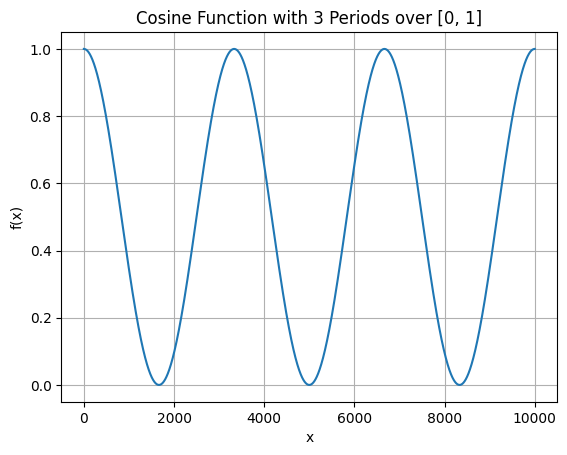

In [18]:
def cosine_function(t, N, x):
    """
    Generate a cosine function that oscillates between 0 and 1,
    with N periods over the interval [0, t].

    Parameters:
    - t: the endpoint of the interval.
    - N: number of periods.
    - x: the input values (can be a numpy array).

    Returns:
    - Function values for the input x.
    """
    return (1 + np.cos(2 * np.pi * N * x / t)) / 2

t = 1  # Interval [0, t] 1 second
N = 3   # Number of periods
x = np.linspace(0, t, 10000)  # x values in the interval [0, t]

# Compute the function values
y = cosine_function(t, N, x)

# Plot the function
plt.plot(y)
plt.title(f"Cosine Function with {N} Periods over [0, {t}]")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

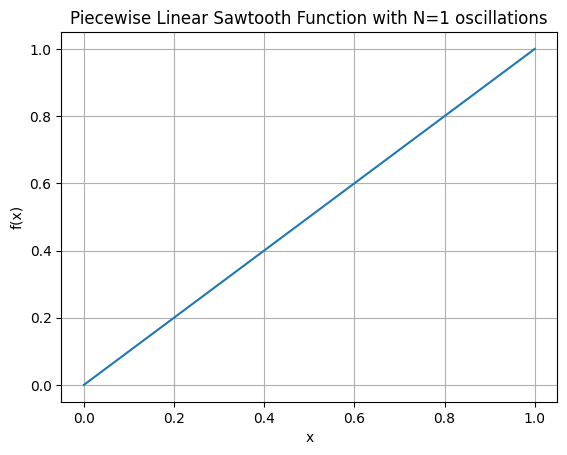

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def piecewise_linear_sawtooth(t, N, x_values):
    """
    Create a piecewise linear function that oscillates between 0 and 1
    exactly N times over the interval [0, t].
    
    Parameters:
    - t: The total time/length of the interval.
    - N: The number of oscillations.
    - x_values: The x-values (time points) where the function is evaluated.
    
    Returns:
    - y_values: The corresponding y-values of the function for the input x_values.
    """
    # Initialize an array to hold the y-values
    y_values = np.zeros_like(x_values)
    
    # Length of each segment (increasing and decreasing)
    segment_length = t / (2 * N)
    
    # Iterate over each x value
    for i, x in enumerate(x_values):
        # Determine the position in the current period [0, t] using modulo operation
        x_mod = x % t
        
        # Determine which segment we're in: rising or falling
        # If we're in the increasing phase (0 to 1)
        if x_mod < segment_length:
            y_values[i] = (2 * N / t) * x_mod
        # If we're in the decreasing phase (1 to 0)
        elif x_mod < 2 * segment_length:
            y_values[i] = 1 - (2 * N / t) * (x_mod - segment_length)
        # Repeat the pattern for the next pair of rising and falling phases
        else:
            # Handle the repeating cycles by dividing into further phases
            cycle_position = (x_mod // segment_length) % 2  # 0 for rising, 1 for falling
            phase_position = x_mod % segment_length  # within the cycle

            if cycle_position == 0:  # Rising
                y_values[i] = (2 * N / t) * phase_position
            else:  # Falling
                y_values[i] = 1 - (2 * N / t) * phase_position

    return y_values

# Parameters
t = 1  # Length of time interval
N = 1  # Number of oscillations

# Create x values (time points) over the interval [0, t]
x_values = np.linspace(0, t, 100000)

# Calculate y values for the piecewise linear sawtooth function
y_values = piecewise_linear_sawtooth(t, N, x_values)
y_values = y_values[: 100000 // 2] 

# Plot the function
plt.plot(x_values[::2], y_values)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Piecewise Linear Sawtooth Function with N={N} oscillations')
plt.grid(True)
plt.show()


0.15000000000000002 amp
0.75 vert
0.15 amp
0.15 vert


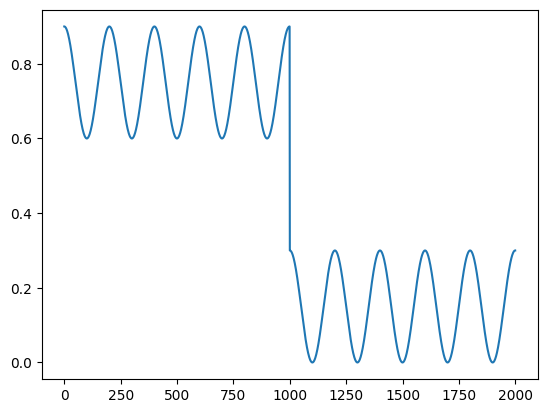

In [81]:
def generate_cosine_wave(start, end, length, frequency):
    # Create a linspace for the x values (0 to 2*pi for one cycle of the cosine wave)
    x = torch.linspace(0, 1, length)
    
    # Amplitude is half the range (difference between start and end divided by 2)
    amplitude = (end - start) / 2
    
    # Vertical shift is the midpoint between start and end
    vertical_shift = (start + end) / 2
    print(amplitude,"amp")
    print(vertical_shift, "vert")
    
    # Create the cosine wave
    cosine_wave = amplitude * torch.cos(frequency * x) + vertical_shift
    
    return cosine_wave

# Parameters
frequency =  10 * np.pi  # Frequency of the cosine wave (adjust as needed)
length = 1000  # Length of each section (50 elements)
start_1, end_1 = 0.6, 0.9  # Range for the first part
start_2, end_2 = 0.0, 0.3  # Range for the second part

# Generate the two parts of the cosine wave
cos_wave_1 = generate_cosine_wave(start_1, end_1, length, frequency)
cos_wave_2 = generate_cosine_wave(start_2, end_2, length, frequency)

# Concatenate both parts to form the final tensor
cosine = np.hstack([cos_wave_1,cos_wave_2])
plt.plot(cosine)
plt.show()


In [82]:
out = torch.tensor(cosine, requires_grad=True).unsqueeze(1).unsqueeze(1).unsqueeze(1) ### previously predicted values
out = out.repeat(1, 4, 1, 1)

In [83]:
import Ergodic_Loss
import sys
k_max = 12
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
import importlib
importlib.reload(Ergodic_Loss)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = 1, n_timesteps = 1000,L = None, in_dim = 1, k_max = k_max,control_energy_reg = 0, density = 'custom', pdf = custom_pdf, max_pdf = 1, num_samples = 10000)
criterion.verbose = True
criterion(x = out, u = None)

tensor([ 1.0000,  0.0065,  0.0127,  0.0134,  0.0026,  0.0093, -0.0063,  0.0070,
        -0.0201, -0.0059,  0.0010, -0.0040]) target distribution
model tensor([[ 1.0000,  0.0662,  0.2892,  0.4302, -0.3854,  0.0202, -0.0766,  0.0353,
         -0.0454,  0.1217,  0.0156, -0.1248],
        [ 1.0000,  0.0498,  0.2607,  0.3177, -0.4136,  0.0173, -0.1155,  0.0724,
         -0.0381,  0.1205, -0.0316, -0.1439],
        [ 1.0000,  0.0606,  0.2017,  0.3345, -0.4748, -0.0196, -0.0610,  0.0327,
         -0.0013,  0.1484,  0.0169, -0.1305],
        [ 1.0000,  0.0718,  0.2774,  0.3834, -0.4057,  0.0492, -0.0948,  0.0377,
         -0.0571,  0.0836, -0.0404, -0.1613]], grad_fn=<CopySlices>) target tensor([ 1.0000,  0.0065,  0.0127,  0.0134,  0.0026,  0.0093, -0.0063,  0.0070,
        -0.0201, -0.0059,  0.0010, -0.0040])
scaling tensor([1.0000e+00, 9.2000e-02, 2.4705e-02, 1.1133e-02, 6.2927e-03, 4.0365e-03,
        2.8066e-03, 2.0635e-03, 1.5806e-03, 1.2493e-03, 1.0122e-03, 8.3666e-04])


tensor(0.1268, grad_fn=<SmoothL1LossBackward0>)

In [84]:
input = torch.tensor(y_values).unsqueeze(1).unsqueeze(1).unsqueeze(1)
print(input.shape)

torch.Size([50000, 1, 1, 1])


In [85]:
criterion(input)

model tensor([[ 1.0000, -0.0535, -0.0431,  0.0096, -0.0462, -0.0129, -0.0497, -0.0241,
         -0.0471,  0.0270,  0.0252,  0.0154]]) target tensor([ 1.0000,  0.0065,  0.0127,  0.0134,  0.0026,  0.0093, -0.0063,  0.0070,
        -0.0201, -0.0059,  0.0010, -0.0040])
scaling tensor([1.0000e+00, 9.2000e-02, 2.4705e-02, 1.1133e-02, 6.2927e-03, 4.0365e-03,
        2.8066e-03, 2.0635e-03, 1.5806e-03, 1.2493e-03, 1.0122e-03, 8.3666e-04])


tensor(0.0303)

In [23]:
import math
k = 4
h_k = math.sqrt(0.5)
kp = (math.pi * k)
(1 / h_k) * (1 / kp) * (5 / 3)  * (math.sin(0.9 * kp) - math.sin(0.6 * kp) + math.sin(0.3 * kp)) 

-0.46702001071907523

In [24]:
import torch
def C_t(samples, X):
    """
        X = [Num_timesteps ,Batch_size, N_Agents, in_dim]
        x = linspace over domain for now R^{1}
        C_t in one dimension
        This is the distribution induced by the current trajectory, we try to minimize distance to wanted trajectory -> However Sobolev space representation was deemed no usefull as computation of Fourier coeffs harder than in original paper
    """
    eps = 1e-10 # Avoid division by 0 error --> Approximation of real function can be neglected and samples resulting in nan may be ignored...
    alpha = 10
    arr = X - samples
    normalized = arr / (arr.abs() + eps)
    diff = torch.diff(normalized, dim = 0)
    sign_changes = diff.abs().sum(dim=(0,2)) / 2
    print((sign_changes) / (sign_changes.mean(dim = 1).unsqueeze(1) + eps), "true value")
    normalized = torch.tanh(alpha * arr)
    diff = torch.diff(normalized, dim = 0)
    sign_changes = diff.abs().sum(dim=(0,2)) / 2
    print((sign_changes) / (sign_changes.mean(dim = 1).unsqueeze(1) + eps), "tanh")

In [25]:
X = torch.ones(10,16,2,1)
X[3,0,1,0] = 0.1
X[6,1,1,0] = 0.1
X[8,1,1,0] = 0.1
X[2,1,0,0] = 0.1
X.requires_grad = True
x = torch.linspace(0.1,1 - 0.1,50)
pred = C_t(x,X)



tensor([[0.5051, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101,
         1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101,
         1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101,
         1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101,
         1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101,
         1.0101, 1.0101, 1.0101, 1.0101, 1.0101],
        [0.5051, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101,
         1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101,
         1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101,
         1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101,
         1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101, 1.0101,
         1.0101, 1.0101, 1.0101, 1.0101, 1.0101],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         

In [26]:
import torch

def forward_product_diff(X, dim=-1, eps=1e-8):
    shifted_X = torch.roll(X, shifts=-1, dims=dim)  # Shift the tensor along the specified dimension
    product = X * shifted_X
    slices = [slice(None)] * X.dim()
    slices[dim] = slice(None, -1)
    return product[tuple(slices)]

In [27]:
def C_t_prod(samples, X):
    """
        X = [Num_timesteps ,Batch_size, N_Agents, in_dim]
        x = linspace over domain for now R^{1}
        C_t in one dimension
        This is the distribution induced by the current trajectory, we try to minimize distance to wanted trajectory -> However Sobolev space representation was deemed no usefull as computation of Fourier coeffs harder than in original paper
    """
    eps = 1e-8
    arr = X - samples
    #print(arr.shape)
    #print(arr)
    diff = forward_product_diff(arr, dim = 0)
    changes = torch.relu((-1) * diff)
    print(torch.tanh(changes * 10)[:,1,:,:])
    sign_changes = torch.tanh(changes * 10).sum(dim=(0,2))
    return sign_changes/ (sign_changes.mean(dim = 1).unsqueeze(1) + eps)

In [28]:
import torch
X = torch.ones(10,16,2,1)
X[1,1,0,0] = 0.3
X[6,1,0,0] = 0.3
print(torch.linspace(1e-3,1- 1e-3,3))
Out = C_t_prod(torch.linspace(1e-3,1- 1e-3,3),X)
print(Out.shape, Out)

tensor([0.0010, 0.5000, 0.9990])
tensor([[[0.0000, 0.7616, 0.0070],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.7616, 0.0070],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.7616, 0.0070],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.7616, 0.0070],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]]])
torch.Size([16, 3]) tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 2.9727, 0.0273],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.

In [29]:
def C_t(samples, X):
    """
        X = [Num_timesteps ,Batch_size, N_Agents, in_dim]
        x = linspace over domain for now R^{1}
        C_t in one dimension
        This is the distribution induced by the current trajectory, we try to minimize distance to wanted trajectory -> However Sobolev space representation was deemed no usefull as computation of Fourier coeffs harder than in original paper
    """
    num_samples = samples.shape[0]
    samples = samples.unsqueeze(0).unsqueeze(0).unsqueeze(0)
    samples = samples.expand((*X.shape[:3], num_samples, X.shape[3])) 
    tensor = X.unsqueeze(-2) - samples ## i want the results to be last dim tensor of shape [Num_timesteps, Batch_size, N_agents, n_samples_x, in_dim] n_samples_x how to samples the objective funciton!
    eps = 1e-10 # Avoid division by 0 error --> Approximation of real function can be neglected and samples resulting in nan may be ignored...
    alpha = 100
    thres_eps = .1
    print(tensor[0,0,0,18,:], "dim = 0")
    print(tensor[1,0,0,18,:], "dim = 1")
    #normalized = arr / (arr.abs() + eps)
    #normalized = arr / (arr.pow(2).sum().sqrt() + eps)
    #print(normalized)
    threshold = (float(X.shape[3]) - thres_eps)
    normalized = torch.tanh(alpha * tensor)
    diff = torch.diff(normalized, dim = 0)
    print(diff[0,0,0,19], "diff")
    absolute_diff = (diff.abs() / 2).sum(dim = -1)
    print(absolute_diff[0,0,0,18])
    absolute_diff -= threshold
    print(absolute_diff[0,0,0,18], absolute_diff[0,0,0,19])
    sign_changes_along_dim = torch.tanh(alpha * torch.relu(absolute_diff))
    print(sign_changes_along_dim)
    sign_changes = sign_changes_along_dim.sum(dim = (0,2))
    print(sign_changes[0,18])
    return (sign_changes) / (sign_changes.mean(dim = 1).unsqueeze(1) + eps)

    #return (torch.relu(() ) + ((1 / (X.shape[-1])) + thres_eps))).sum(dim = (0,2)) ### 
    #sign_changes = diff.abs().sum(dim=(0,2)) / 2
    #print(sign_changes.shape)
    #print(sign_changes.mean(dim = 1).shape)
    #return (sign_changes) / (sign_changes.mean(dim = 1).unsqueeze(1) + eps)

In [30]:
linspace_1 = torch.linspace(0, 1, 5)
linspace_2 = torch.linspace(0, 1, 5)
grid_x, grid_y = torch.meshgrid(linspace_1, linspace_2)
x = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)
print(x.shape)

torch.Size([25, 2])


c:\Users\prass\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [31]:
X = torch.ones(3,2,2,2)
X[0,0,0,:] = torch.tensor([0.3,0.3])
X.requires_grad = True
pred_1 = C_t(x,X)
#print(pred_1[0,0,0,:,:])
print(x)


tensor([-0.4500, -0.4500], grad_fn=<SliceBackward0>) dim = 0
tensor([0.2500, 0.2500], grad_fn=<SliceBackward0>) dim = 1
tensor([2., 1.], grad_fn=<SelectBackward0>) diff
tensor(2., grad_fn=<SelectBackward0>)
tensor(0.1000, grad_fn=<SelectBackward0>) tensor(-0.4000, grad_fn=<SelectBackward0>)
tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
           1., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

In [32]:
print(result.shape)
print(X.shape)
dim1 = (X[:,:,:,0].unsqueeze(-1) - result[:,0])
dim2 = (X[:,:,:,1].unsqueeze(-1) - result[:,1])
print(dim1.shape, dim2.shape)
tensor = torch.stack((dim1, dim2), dim = -1)
tensor.shape

NameError: name 'result' is not defined

In [ ]:
X = torch.ones(2,2,2,2)
i = 55
broadcast_result = result.unsqueeze(0).unsqueeze(0).unsqueeze(0)
broadcast_result = broadcast_result.expand((*X.shape[:3], 100, X.shape[3])) 
tensor = X.unsqueeze(-2) - broadcast_result 
print(tensor[0,0,0,i,:], result[i,:]) 

tensor([0.4444, 0.4444]) tensor([0.5556, 0.5556])


In [ ]:
import time
criterion.verbose = True
epochs = 300  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
iters = 0

        ### LBFGS with line search basically guarantees decrease at high complexity
       #optimizer = optim.LBFGS(model.parameters(), line_search_fn = 'strong_wolfe') 

    print(criterion.k_compare)
    while True:
        iters += 1
        running_loss = 0.0 
        for samples in range(n_samples // batch_size):
            start_time = time.time()
            model.init_hidden(batch_size = batch_size)
            optimizer.zero_grad()
            outputs, control = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
            loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if show:
                show = False
                criterion.verbose = False
                print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)    
        avg_loss = running_loss / (n_samples // batch_size)
        if avg_loss < 0.004 or (iters > 500): ## by elastic net this is like 1e-2 in sup norm 
            print(iters, "number of iteration until convergence")
            break
        train_loss.append(avg_loss)
        print(f"Epoch [{iters}], Loss: {avg_loss:.6f}")
    plt.plot(train_loss)
    plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u, number of coefficients: {criterion.k_compare}')
    plt.legend()
    plt.show()
    print("Training Complete!")

In [12]:
import torch
batch_size = 2
N_agents = 3
in_dim = 1

# Initialize tensor x of shape [Batch_size, N_Agents, in_dim]
x = torch.randn(batch_size, N_agents, in_dim)

# Step 1: Compute pairwise Euclidean distances between agents
# Expand the tensor to compute distances between all pairs of agents
x_expanded = x.unsqueeze(2) - x.unsqueeze(1)  # Shape becomes [Batch_size, N_Agents, N_Agents, in_dim]

# Compute the squared differences, sum along the last dimension, and take the square root
distances = torch.sqrt(torch.sum(x_expanded ** 2, dim=-1))
mask = torch.ones_like(distances, dtype=torch.bool)
mask = mask.triu(diagonal=1) 
flattened_distances = distances.masked_select(mask).view(batch_size, -1)

In [15]:
1 / (distances + 1e-5) * torch.randn_like(distances)

tensor([[[ 5.8846e+04, -4.2418e-01,  6.9402e-02],
         [ 3.8882e-02,  2.1499e+04,  1.6365e-01],
         [ 9.9245e-01,  2.2898e-01,  6.5256e+03]],

        [[-5.4694e+04, -1.4236e+00,  1.6085e-01],
         [ 7.5292e-01, -6.9859e+04, -1.0641e+00],
         [ 2.8316e-01,  1.7072e+00,  9.3275e+03]]])

In [24]:
L1 = 1
L2 = 1
dist = (distances)**(-2) * torch.sqrt(torch.tensor(L1**2 + L2**2))
dist[dist == float('inf')] = 1.0

